# llc4320 drifters spectra: Lagrangian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt
import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5947137.datarmor0/parcels-502027/libparcels_random_aeb5c84b-e790-4fed-b5f0-a0a29ae15631.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    w = cluster.scale(jobs=15)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

<Client: 'tcp://10.148.0.228:49804' processes=77 threads=77, memory=1.20 TiB>

---
# Lagrangian spectra
### last update: 2021.07.22

## 1. Zonal averaging (from raw Lagrangian spectra)

In [4]:
D = '/home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics'

In [5]:
# load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [5]:
V = ["mean0","mean1","mean2"]

for v in V:

    # read raw spectra
    df = p.load_diagnostic('spectra_uv_T60_%s'%(v))
    df.head()

    # add bathymetry to dataframe
    def interp_bathy(df):
        bathy = ut.load_bathy(15)
        ds = df[['lon','lat']].to_xarray()
        ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
        df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
        return df.assign(**{bathy.name: df_interpolated})

    df = df.map_partitions(interp_bathy)

    # filter out depth ranges
    df = df[df['h']>500]
    df.head()

    # bin geographically
    dl = 1.
    lat_bins = np.arange(-60, 60, dl)

    df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)

    E = df.groupby(['lat_cut']).mean().compute()

    #Converting pandas dataframe in xarray dataset:
    ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
                  .drop(columns=['time','lon','lat', 'h'])
                  .reset_index(), 
                  id_vars=['lat_cut',], 
                  var_name='frequency')
                  .rename(columns={'lat_cut': 'lat_bins', 
                                   'value': 'E'},
                         )
         ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
    ds['frequency'] = ds['frequency'].astype(float)
    ds = ds.sortby('frequency')

    p.store_diagnostic('spectra_uv_T60_%s_lat'%(v), ds, overwrite=True)

spectra_uv_T60_mean0_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean0_lat.zarr
spectra_uv_T60_mean1_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat.zarr
spectra_uv_T60_mean2_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean2_lat.zarr


## Plots

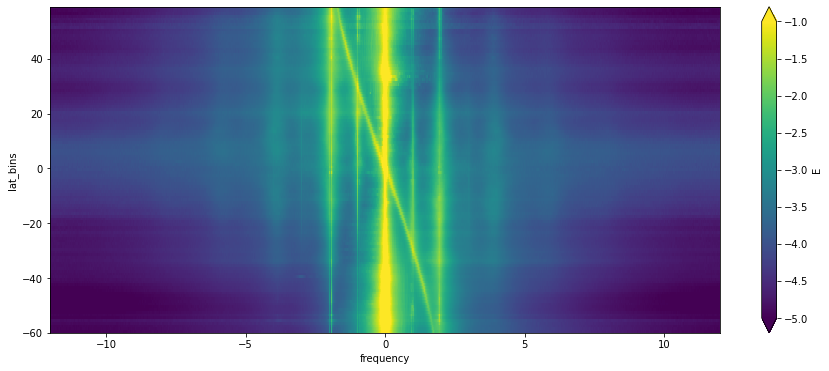

In [6]:
# no detrending
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat.zarr')

# spectra_raw_uv_mean1_lat_xyu
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

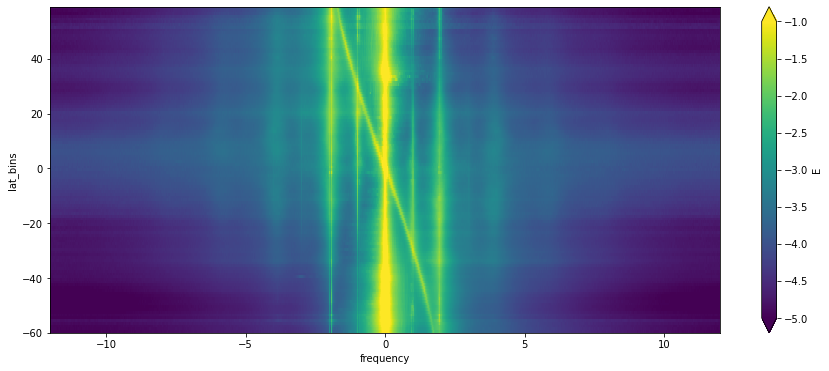

In [7]:
# no detrending
ds = p.load_diagnostic('spectra_uv_T60_mean1_lat.zarr')

# spectra_raw_uv_mean1_lat_xyu
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

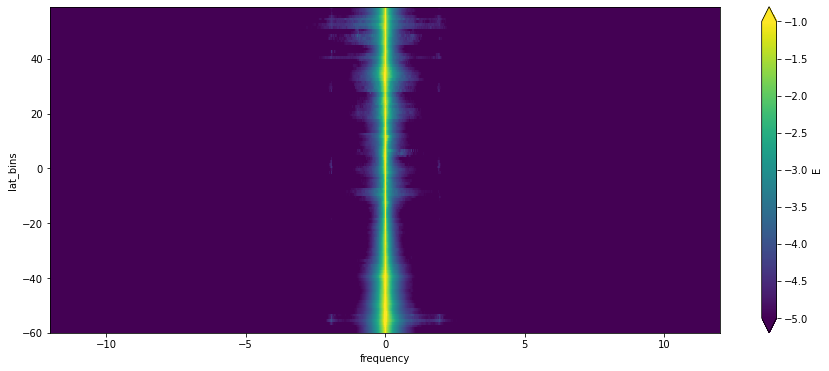

In [8]:
# no detrending
ds = p.load_diagnostic('spectra_uv_T60_mean2_lat.zarr')

# spectra_raw_uv_mean1_lat_xyu
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

---
## 2. lat x lon binning

In [ ]:
V = ["mean0","mean1","mean2"]

for v in V:

    # read raw Lagrangian spectra
    df = p.load_diagnostic('spectra_uv_T60_%s'%(v))
    df.head()

    # add bathymetry to dataframe
    def interp_bathy(df):
        bathy = ut.load_bathy(15)
        ds = df[['lon','lat']].to_xarray()
        ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
        df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
        return df.assign(**{bathy.name: df_interpolated})
    df = df.map_partitions(interp_bathy)

    # filter out depth ranges
    df = df[df['h']>500]
    df.head()

    # bin geographically
    dl = 2.
    lon_bins = np.arange(-180.,180., dl)
    lat_bins = np.arange(-90, 90, dl)
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
    df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)
    df = df.reset_index().persist()
    E = df.groupby(['lon_cut', 'lat_cut']).mean().compute()
    
    #Converting pandas dataframe in xarray dataset:
    index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                       E.index.map(lambda v: v[1].mid)
                                      ], 
                                      names=('lon_cut', 'lat_cut'),
                                     )
    ds = (pd.melt(E.set_index(index)
                  .drop(columns=['time','lon','lat', 'h', 'trajectory'])
                  .reset_index(), id_vars=['lon_cut', 'lat_cut',],
                  var_name='frequency',
                 )
          .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
         ).to_xarray().set_index(index=['lon_bins', 'lat_bins','frequency']).unstack()
    ds['frequency'] = ds['frequency'].astype(float)
    ds = ds.sortby('frequency')
    ds = ds.chunk({'frequency': 100})

    # store diagnostic
    p.store_diagnostic('spectra_uv_T60_%s_lat_lon'%(v), ds, overwrite=True)    

In [9]:
# This works for 1*1 bins
V = ["mean0","mean1","mean2"]

for v in V:

    
    ###### north ######
    # read raw Lagrangian spectra
    df = p.load_diagnostic('spectra_uv_T60_%s'%(v))
    df.head()

    # add bathymetry to dataframe
    def interp_bathy(df):
        bathy = ut.load_bathy(15)
        ds = df[['lon','lat']].to_xarray()
        ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
        df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
        return df.assign(**{bathy.name: df_interpolated})
    df = df.map_partitions(interp_bathy)

    # filter out depth ranges
    df = df[df['h']>500]
    df.head()

    # bin geographically
    dl = 2. # 1
    lon_bins = np.arange(-180.,180., dl)
    lat_bins = np.arange(0, 60, dl)
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
    df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)
    df = df.reset_index().persist()
    E = df.groupby(['lon_cut', 'lat_cut']).mean().compute()
    
    #Converting pandas dataframe in xarray dataset:
    index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                       E.index.map(lambda v: v[1].mid)
                                      ], 
                                      names=('lon_cut', 'lat_cut'),
                                     )
    ds = (pd.melt(E.set_index(index)
                  .drop(columns=['time','lon','lat', 'h', 'trajectory'])
                  .reset_index(), id_vars=['lon_cut', 'lat_cut',],
                  var_name='frequency',
                 )
          .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
         ).to_xarray().set_index(index=['lon_bins', 'lat_bins','frequency']).unstack()
    ds['frequency'] = ds['frequency'].astype(float)
    ds = ds.sortby('frequency')
    ds = ds.chunk({'frequency': 100})
    ds_north = ds
    
    
    
    ###### south ######
    # read raw Lagrangian spectra
    df = p.load_diagnostic('spectra_uv_T60_%s'%(v))
    df.head()

    # add bathymetry to dataframe
    def interp_bathy(df):
        bathy = ut.load_bathy(15)
        ds = df[['lon','lat']].to_xarray()
        ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
        df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
        return df.assign(**{bathy.name: df_interpolated})
    df = df.map_partitions(interp_bathy)

    # filter out depth ranges
    df = df[df['h']>500]
    df.head()
    
    # bin geographically
    dl = 2.
    lon_bins = np.arange(-180.,180., dl)
    lat_bins = np.arange(-60, 0.5, dl)
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
    df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)
    df = df.reset_index().persist()
    E = df.groupby(['lon_cut', 'lat_cut']).mean().compute()
    
    #Converting pandas dataframe in xarray dataset:
    index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                       E.index.map(lambda v: v[1].mid)
                                      ], 
                                      names=('lon_cut', 'lat_cut'),
                                     )
    ds = (pd.melt(E.set_index(index)
                  .drop(columns=['time','lon','lat', 'h', 'trajectory'])
                  .reset_index(), id_vars=['lon_cut', 'lat_cut',],
                  var_name='frequency',
                 )
          .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
         ).to_xarray().set_index(index=['lon_bins', 'lat_bins','frequency']).unstack()
    ds['frequency'] = ds['frequency'].astype(float)
    ds = ds.sortby('frequency')
    ds = ds.chunk({'frequency': 100})
    ds_south = ds   
    
    # together
    ds_all = xr.concat([ds_south, ds_north], dim="lat_bins")
    
    # store diagnostic
    p.store_diagnostic('spectra_uv_T60_%s_lat_lon_2deg'%(v), ds_all, overwrite=True)    

spectra_uv_T60_mean0_lat_lon_2deg diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean0_lat_lon_2deg.zarr
spectra_uv_T60_mean1_lat_lon_2deg diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat_lon_2deg.zarr
spectra_uv_T60_mean2_lat_lon_2deg diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean2_lat_lon_2deg.zarr


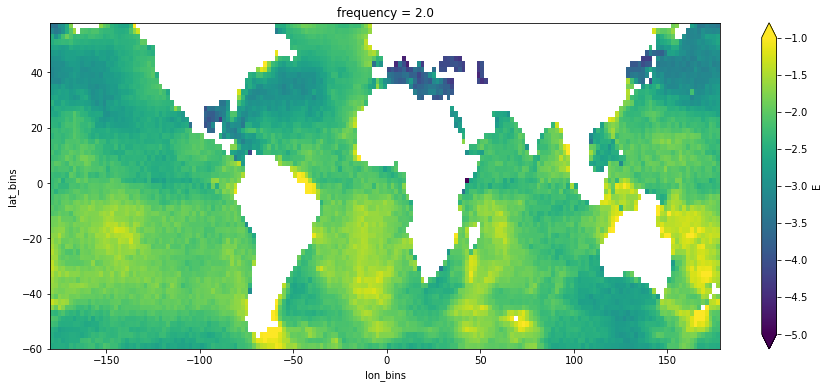

In [11]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_2deg.zarr')
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E.sel(frequency=2)).plot(x='lon_bins',cmap='viridis', vmin=-5, vmax=-1)

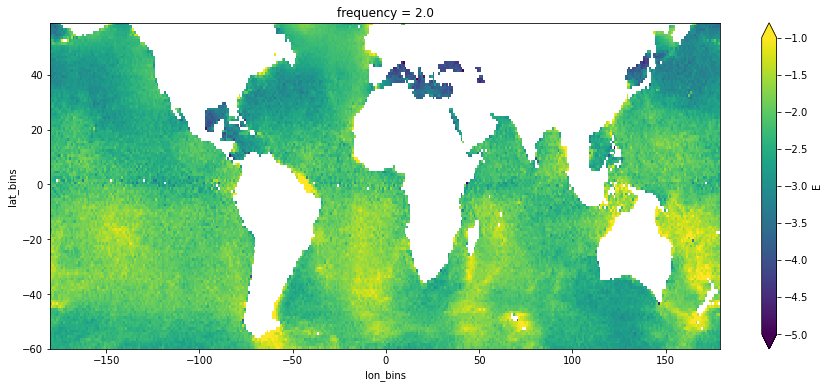

In [6]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon.zarr')
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E.sel(frequency=2)).plot(x='lon_bins',cmap='viridis', vmin=-5, vmax=-1)

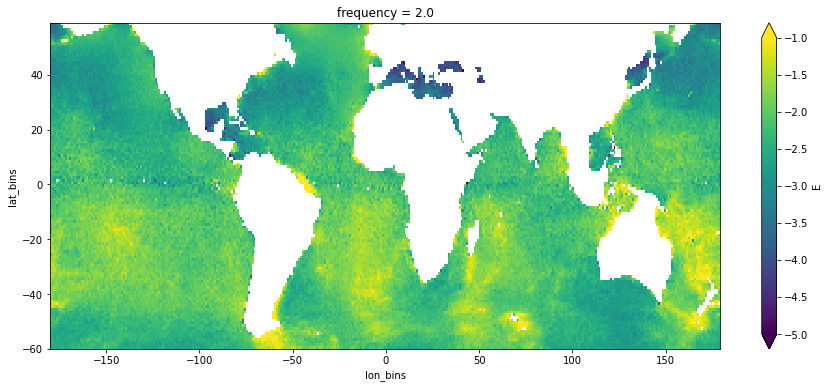

In [7]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T60_mean1_lat_lon.zarr')
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E.sel(frequency=2)).plot(x='lon_bins',cmap='viridis', vmin=-5, vmax=-1)

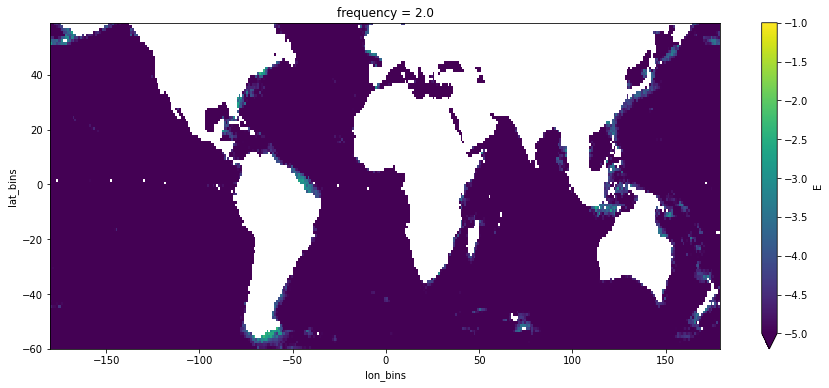

In [8]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T60_mean2_lat_lon.zarr')
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E.sel(frequency=2)).plot(x='lon_bins',cmap='viridis', vmin=-5, vmax=-1)

_____________
## 3. lon x lat for band-integrated KE

In [12]:
V = ["mean0","mean1","mean2"]

for v in V:
    
    ds = p.load_diagnostic('spectra_uv_T60_%s_lat_lon_2deg.zarr'%(v))

    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(ds.lat_bins))
    f_cpd_llc = f_llc*86400/2./np.pi

    bands = {'total': (0., 12), 'low': (0., .5), 
             'diurnal_0dot1': (0.9, 1.1), 'diurnal_0dot2': (0.8, 1.2), 'diurnal_0dot3': (0.7, 1.3), 'diurnal_0dot4': (0.6, 1.4),
             'semidiurnal_0dot1': (1.9, 2.1), 'semidiurnal_0dot2': (1.8, 2.2), 'semidiurnal_0dot3': (1.7, 2.3), 'semidiurnal_0dot4': (1.6, 2.4),
             'inertial_0dot1':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),'inertial_0dot2':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),
             'inertial_0dot3':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),'inertial_0dot4':(f_cpd_llc.values.min(),f_cpd_llc.values.max())
            }
    
    domega = float(ds.frequency[1]- ds.frequency[0])

    Eb = {}
    for b, bounds in bands.items():
        #print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))

        if b == "inertial_0dot1":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.1), 
                        drop=False,
                       )
        elif b == "inertial_0dot2":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.2), 
                        drop=False,
                       )
        elif b == "inertial_0dot3":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.3), 
                        drop=False,
                       )
        elif b == "inertial_0dot4":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.4), 
                        drop=False,
                       )            
            
        else:
            _E = ds.E.where((np.abs(ds.frequency)>=bounds[0]) & (np.abs(ds.frequency)<=bounds[1]), 
                            drop=False,
                           )

        E = domega * _E.sum('frequency')    
        Eb[b] = E.persist()

    # converts to single dataset and store:
    E = xr.concat(list(Eb.values()), 
                  dim=pd.Index(list(Eb.keys()),name='frequency_band'),
                 )

    # store diagnostic
    p.store_diagnostic('spectra_uv_T60_%s_lat_lon_bands_2deg'%(v), E.to_dataset(), overwrite=True)

spectra_uv_T60_mean0_lat_lon_bands_2deg diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean0_lat_lon_bands_2deg.zarr
spectra_uv_T60_mean1_lat_lon_bands_2deg diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat_lon_bands_2deg.zarr
spectra_uv_T60_mean2_lat_lon_bands_2deg diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean2_lat_lon_bands_2deg.zarr


In [13]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands_2deg.zarr')
ds

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 59, lon_bins: 179)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.0 -57.0 -55.0 ... 53.0 55.0 57.0
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
Data variables:
    E               (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 179, 30), meta=np.ndarray>

In [12]:
ds.frequency_band

<xarray.DataArray 'frequency_band' (frequency_band: 9)>
array(['low', 'diurnal_0dot1', 'diurnal_0dot2', 'semidiurnal_0dot1',
       'semidiurnal_0dot2', 'semidiurnal_0dot3', 'semidiurnal_0dot4',
       'inertial_0dot1', 'inertial_0dot2'], dtype=object)
Coordinates:
  * frequency_band  (frequency_band) object 'low' ... 'inertial_0dot2'

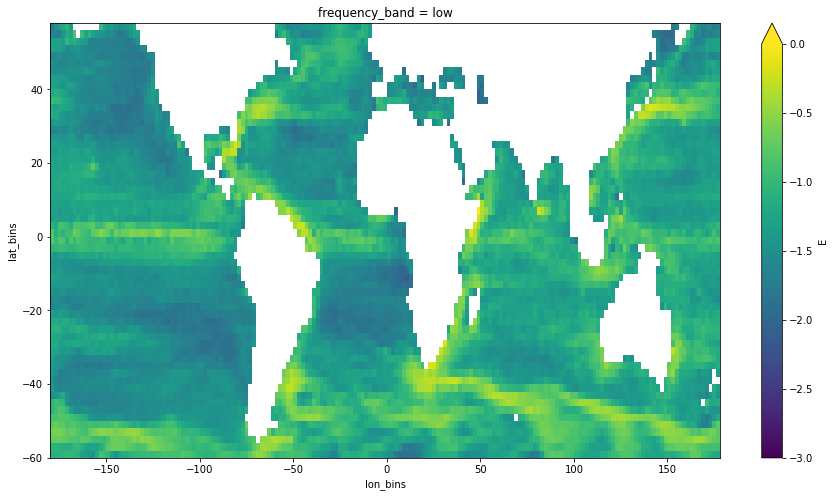

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='low').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

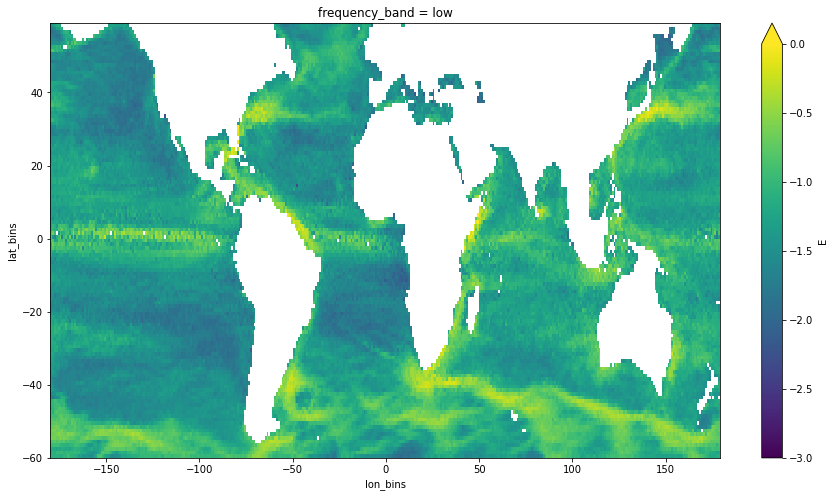

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='low').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

_________________
## 4. Zonal averaging (from 2D binned spectra)

In [15]:
V = ["mean0", "mean1", "mean2"]

for v in V:

    ds = p.load_diagnostic('spectra_uv_T60_%s_lat_lon.zarr'%(v))
    E = ds.mean('lon_bins')    
    p.store_diagnostic('spectra_uv_T60_%s_lat_from_2Dbinned_spectra'%(v), E, overwrite=True)
    print('<%s - allready processed>'%(v))        

spectra_uv_T60_mean0_lat_from_2Dbinned_spectra diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean0_lat_from_2Dbinned_spectra.zarr
<mean0 - allready processed>
spectra_uv_T60_mean1_lat_from_2Dbinned_spectra diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat_from_2Dbinned_spectra.zarr
<mean1 - allready processed>
spectra_uv_T60_mean2_lat_from_2Dbinned_spectra diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean2_lat_from_2Dbinned_spectra.zarr
<mean2 - allready processed>


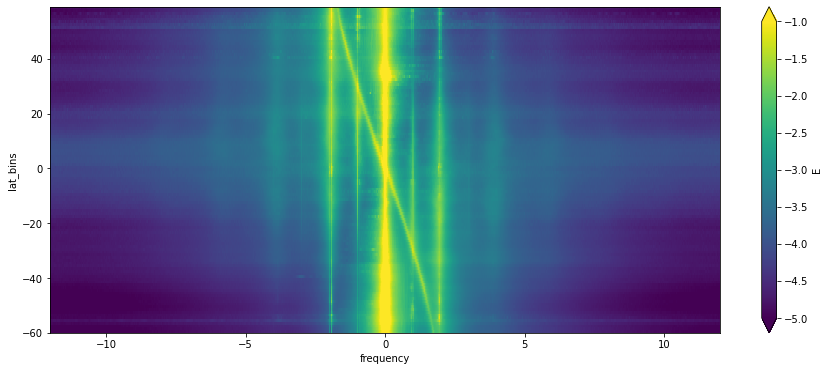

In [17]:
# load
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_from_2Dbinned_spectra.zarr')

fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

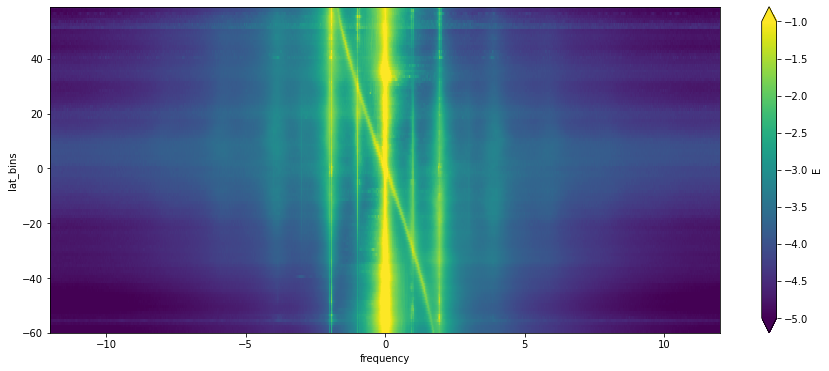

In [18]:
# load
ds = p.load_diagnostic('spectra_uv_T60_mean1_lat_from_2Dbinned_spectra.zarr')

fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

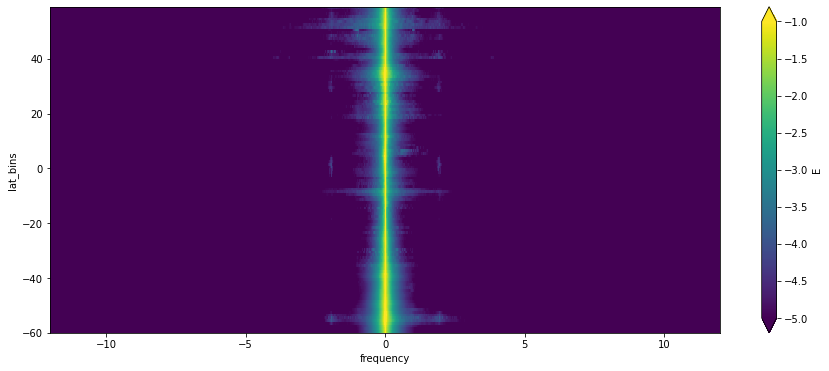

In [19]:
# load
ds = p.load_diagnostic('spectra_uv_T60_mean2_lat_from_2Dbinned_spectra.zarr')

fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

## Close cluster

In [15]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
